El aprendizaje reforzado

Utilizaremos un algortimo DDQN (Double Deep Q Learning) para superar el primer nivel del videojuego Super Mario Bros. lanzado por la compañía Nintendo para su plataforma NES

In [1]:
import os, sys
import numpy as np
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros import actions
from gym import Wrapper
import matplotlib.pyplot as plt
import collections
from collections import deque
import random
import gym
import torch
from gym.spaces import Box
from util.class_tb import make_env


In [ ]:
Utilizaremos una librería

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env, actions.RIGHT_ONLY)

In [3]:
env.observation_space
# Tenemos imagenes RGB de 240x256 pixeles

Box(0.0, 1.0, (4, 84, 84), float32)

In [10]:
env.action_space.n

5

In [11]:
Las 12 acciones corresponden a la siguiente combinación de botones:

- ['NOOP']
- ['right']
- ['right', 'A']
- ['right', 'B']
- ['right', 'A', 'B']
- ['A']
- ['left']
- ['left', 'A']
- ['left', 'B']
- ['left', 'A', 'B']
- ['down']
- ['up']

['NOOP']

In [3]:
import torch.nn as nn
import numpy as np

class ConvNet(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)



In [4]:
model = ConvNet(env.observation_space.shape, env.action_space.n) 
model.to(torch.device("cuda:0"))

target_model = ConvNet(env.observation_space.shape, env.action_space.n) 
target_model.to(torch.device("cuda:0"))


ConvNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'keras.backend' has no attribute 'tensorflow_backend'

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3693430766204726633
]


In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, actions.SIMPLE_MOVEMENT)

In [ ]:
env.action_space.n

7

Vemos los siguientes atributos

Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 2.0, Done: False
Estado: (240, 256, 3), Recompensa: 2.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 0.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 1.0, Done: False
Estado: (240, 256, 3), Recompensa: 2.0, Done: False
Estado: (240

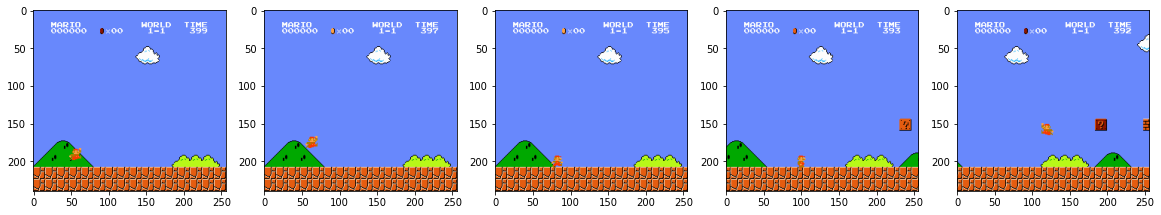

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))

env.reset()

done = False
for i in range(50):
    if i % 10:
        state, reward, done, _ = env.step(env.action_space.sample()) # Ejecuta una acción aleatoria
        print(f'Estado: {state.shape}, Recompensa: {reward}, Done: {done}')
        ax[i//10].imshow(state)

In [ ]:
import random
episodes = 5

for i in range(episodes):
    env.reset()
    done = False
    score = 0
    while not done:
        action = random.choice(np.arange(0, 7))
        state, reward, done, _ = env.step(action)
        score += reward
    print(f'Episode: {i + 1} -> Score: {score}')


Episode: 1 -> Score: 1009.0
Episode: 2 -> Score: 230.0
Episode: 3 -> Score: 587.0
Episode: 4 -> Score: 543.0
Episode: 5 -> Score: 794.0


In [ ]:
env = wrap_nes("SuperMarioBros-1-2-v0", actions.SIMPLE_MOVEMENT)

In [ ]:
def epsilon_greedy(epsilon, model, state):
    '''Exploración vs predicción'''
    random = np.random.uniform(0, 1, size=1)
    if (1 - epsilon) > random:
        action = model.predict(state)
    else:
        action = env.action_space.sample()
    
    epsilon *= 0.99
    epsilon = max(epsilon, 0.01)

    return action, epsilon

target = γ * maxaQ(s′,a′,θ) + rt 

In [4]:
model = ConvNet(env.observation_space.shape, env.action_space.n) 
model.cuda()

target_model = ConvNet(env.observation_space.shape, env.action_space.n) 
target_model.cuda()

ConvNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [21]:
episode = 10000
gamma = 0.95
#epsilon = 1
epsilon = 0.01
epsilon_decay = 0.999
state_memory = deque(maxlen=5000)
action_memory = deque(maxlen=5000)
reward_memory = deque(maxlen=5000)
new_state_memory = deque(maxlen=5000)
done_memory = deque(maxlen=5000)
frame_count = 0
score_list = []
batch_size = 32
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [22]:
import pickle
score_list = pickle.load(open('score_list3.h5', 'rb'))

In [23]:
def memory_replay(model, target_model, batch_size, gamma, state_memory, action_memory, reward_memory, new_state_memory, done_memory, optimizer):
    if len(state_memory) < batch_size: 
        return None
    else:
        #samples = random.sample(memory, batch_size)
        #states = np.array([sample[0] for sample in samples])
        #next_state = np.array([sample[3] for sample in samples])
        idx = random.choices(range(len(reward_memory)), k=batch_size)

        STATE = torch.tensor(np.array(state_memory)[idx]).cuda()
        ACTION = torch.tensor(np.array(action_memory)[idx]).cuda()
        REWARD = torch.tensor(np.array(reward_memory)[idx]).cuda()
        STATE2 = torch.tensor(np.array(new_state_memory)[idx]).cuda()
        DONE = torch.ByteTensor(np.array(done_memory)[idx]).cuda()
        '''
        current = model(STATE).cuda()
        target = target_model(STATE2).cuda().detach()

        for index in range(len(target)):
        
            done = DONE[index]
            if not done:
                max_future_q = torch.max(target[index])
                
                new_q = REWARD[index] + (gamma * max_future_q)
            else:
                new_q = REWARD[index]
        
            target[index][ACTION] = float(new_q)
        '''
        
        state_action_values = model(STATE).gather(1, ACTION.unsqueeze(-1)).squeeze(-1)
        next_state_values = target_model(STATE2).max(1)[0]
        next_state_values[DONE] = 0.0
        next_state_values = next_state_values.detach()
        expected_state_action_values=(next_state_values * gamma) + REWARD
        expected_state_action_values = expected_state_action_values.float()
        loss_t = nn.MSELoss()(state_action_values, expected_state_action_values).cuda()
        optimizer.zero_grad()


        #l1 = nn.SmoothL1Loss().to('cuda')
        #loss = l1(current, target)
        loss_t.backward()
        optimizer.step()

In [35]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = make_env(env, actions.RIGHT_ONLY)

for i in range(episode):
    score = 0   
    done = False
    state = env.reset()
    state = np.array(state)
    for u in range(env.spec.max_episode_steps):
        
        if frame_count%1000==0:
            target_model.load_state_dict(model.state_dict())
            print('Update')  # Doble Q learning
        env.render(mode='human')
        
        random_number = random.uniform(0, 1)
        if (1 - epsilon) >= random_number:
            action = torch.argmax(model(torch.tensor(state).cuda().unsqueeze(0).cuda())).item()
        else:
            action = env.action_space.sample()
            epsilon *= epsilon_decay
            epsilon = max(epsilon, 0.01)
        
        new_state, reward, done, _ = env.step(action)
        new_state = np.array(new_state)
        score += reward

        
        #target = target_model.predict(np.expand_dims(new_state, 0))
        #if not done:
        #    target[0][action] = reward + (gamma * max(target_model.predict(np.expand_dims(new_state, 0))[0]))
        #else:
        #    target[0][action] = reward
        #model.fit(np.expand_dims(state, 0), np.array(target), verbose=0)

        state_memory.append(state)
        action_memory.append(action)
        reward_memory.append(reward)
        new_state_memory.append(new_state)
        done_memory.append(done)
        
        memory_replay(model, target_model, batch_size, gamma, state_memory, action_memory, reward_memory, new_state_memory, done_memory, optimizer)
        state = new_state
        frame_count += 1
        
        if done:
            break

    if i % 10 == 0:
        torch.save(model.state_dict(), 'intento_pytorch2.pt')
        print(f'Episode: {i} --> Score {score}')
        print('epsilon: ', epsilon)
        print('frame_count: ', frame_count)
        print(len(action_memory))
    play()
    score_list.append(score)
    
    

env.close()


ipykernel_launcher:34: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


KeyboardInterrupt: 

In [52]:
import pickle
pickle.dump(score_list[200:850], open('score_listfinal.h5', 'wb'))

In [36]:
len(score_list)

1170

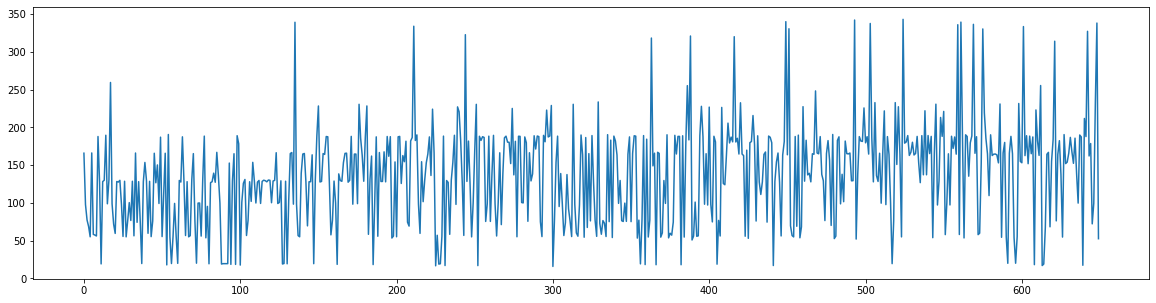

In [53]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([x for x in range(650)], score_list[200:850])

In [61]:
torch.save(model.state_dict(), 'casi_final.h5')

In [39]:
model_loaded = ConvNet(env.observation_space.shape, env.action_space.n) 
model_loaded.load_state_dict(torch.load('yujuuu.h5'))
model_loaded.eval()


ConvNet(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=5, bias=True)
  )
)

In [49]:
def play():    
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env, actions.RIGHT_ONLY)


    state = np.array(env.reset())

    done = False
    score = 0
    while not done:
        env.render(mode='human')
        action = torch.argmax(model_loaded(torch.tensor(state).unsqueeze(0))).item()
        new_state, reward, done, _ = env.step(action)
        state = new_state
        score += reward
    env.close()
    #if score > 300:
    #    torch.save(model.state_dict(), 'yujuuu.h5')


In [51]:
play()

In [32]:
env.close()